<a href="https://colab.research.google.com/github/Fausztusz/Machine-vision/blob/master/Labor6_IKM_GL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch

A mostani labor témája a PyTorch függvénykönyvtár használata lesz. Ehhez először néhány fontos könyvtár installálására lesz szükség.

## GPU és CUDA ellenőrzése

A !nvcc --version parancs segítségével ellenőrizhető a CUDA verziója

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


## Fontos könyvtárak installálása

Torch, torchvision, progressbar, lightning

In [0]:
!pip3 install torch torchvision pytorch-lightning

## PyTorch és CUDA ellenőrzése

In [0]:
import torch
print(torch.cuda.is_available())

True


## Számítási gráf numpy segítségével



In [0]:
import numpy as np

np.random.seed(42)

a = np.random.randn(2)
b = np.random.randn(2)
c = np.random.randn(2)

d = 2*a+0.5*b
e = np.sum(c*d)

print(e)

grad_e = np.ones(2)
grad_c = grad_e*d
grad_d = grad_e*c
grad_a = grad_d*2
grad_b = grad_d*0.5

print(grad_a,grad_b,grad_c)

-0.42199704138300664
[-0.46830675 -0.46827391] [-0.11707669 -0.11706848] [1.31727258 0.48498633]


## Számítási gráf PyTorch segítségével

In [0]:
import torch

np.random.seed(42)

a = torch.Tensor(np.random.randn(2)).requires_grad_(True)
b = torch.Tensor(np.random.randn(2)).requires_grad_(True)
c = torch.Tensor(np.random.randn(2)).requires_grad_(True)

d = 2*a+0.5*b
e = (c*d).sum()

print(e.item())
e.backward()
print(a.grad, b.grad, c.grad)

-0.4219970405101776
tensor([-0.4683, -0.4683]) tensor([-0.1171, -0.1171]) tensor([1.3173, 0.4850])


## Lineáris modell definiálása

In [0]:
from torch import nn

class Linear(nn.Module):
  def __init__(self,Nin,Nout):
    super(Linear,self).__init__()
    self.W = torch.randn(Nout,Nin).requires_grad_(True)
  def forward(self,x):
    return torch.addmv(torch.zeros(2),self.W,x)
  
myNeuron = Linear(128,2)
myInput = torch.randn(128)
y = myNeuron(myInput)
print(y)

tensor([-20.7465,  -1.6387], grad_fn=<AddmvBackward>)


## Lineáris modell tanítása

tensor(0.0729, grad_fn=<NormBackward0>)
2.490078639006242


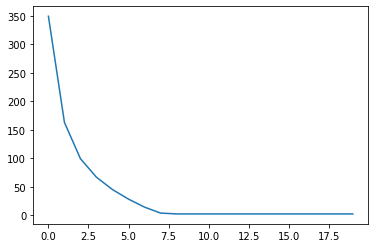

In [0]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

torch.manual_seed(42)

N = 128
myNeuron = Linear(N,2)
trainX = torch.randn(N,128)
trainY = torch.randn(N,2)
lr = 1e-3

losses = []
for i in range(20):
  running_loss = 0
  for x,y in zip(trainX,trainY):

    y_pred = myNeuron(x)
    loss = ((y-y_pred)**2).sum() + 10*myNeuron.W.norm(2)
    loss.backward()
    with torch.no_grad():
      myNeuron.W -= lr*myNeuron.W.grad
      myNeuron.W.grad.zero_()
    running_loss += loss.item()
  losses.append(running_loss/N)
print(myNeuron.W.norm(2))
print(losses[-1])
plt.plot(losses)

## Beépített függvények használata

In [0]:
class myMLP(nn.Module):
  def __init__(self,Nin,Nout,Nhid):
    super(myMLP,self).__init__()
    self.L1 = nn.Linear(Nin,Nhid)
    self.L2 = nn.Linear(Nhid,Nout)
  
  def forward(self,x):
    return self.L2(torch.sigmoid(self.L1(x)))
  
myNet = myMLP(128,2,256)
y = myNet(myInput)
print(y)

tensor([ 0.1688, -0.0459], grad_fn=<AddBackward0>)


## Tanítás beépített függvényekkel

9.373290140501922e-06


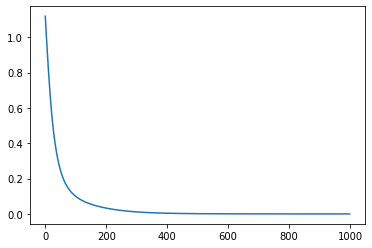

In [0]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

torch.manual_seed(42)

N = 256

dataset = TensorDataset(trainX,trainY)
dataloader = DataLoader(dataset,batch_size=4)

myNet = myMLP(128,2,256)

optimizer = optim.SGD(myNet.parameters(),lr=1e-2,weight_decay=1e-5)

criterion = nn.MSELoss()

losses = []
epochNum = 1000
bestLoss = 10000

for i in range(epochNum):
  running_loss = 0
  
  for x,y in dataloader:
    optimizer.zero_grad()
    y_pred = myNet(x)
    loss = criterion(y_pred,y)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  running_loss /= len(dataloader)
  losses.append(running_loss)
  if running_loss < bestLoss:
    bestLoss = running_loss
    torch.save(myNet.state_dict(),"myNet.pth")
print(bestLoss)
plt.plot(losses)

## Tanítás CUDA segítségével

0.0011991395185759757


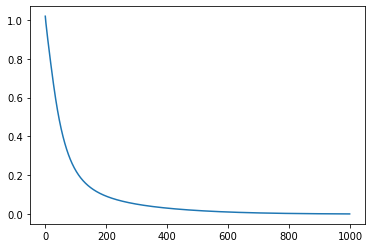

In [0]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

dataloader = DataLoader(dataset,batch_size=8)

myNet = myMLP(128,2,256).cuda()

optimizer = optim.SGD(myNet.parameters(),lr=1e-2,weight_decay=1e-5)

criterion = nn.MSELoss().cuda()

losses = []
epochNum = 1000
bestLoss = 10000

for i in range(epochNum):
  running_loss = 0
  
  for x,y in dataloader:
    x = x.cuda()
    y = y.cuda()
    optimizer.zero_grad()
    y_pred = myNet(x)
    loss = criterion(y_pred,y)
    loss.backward()
    optimizer.step()
    running_loss += loss.cpu().item()
  running_loss /= len(dataloader)
  losses.append(running_loss)
  if running_loss < bestLoss:
    bestLoss = running_loss
    torch.save(myNet.state_dict(),"myNet.pth")
print(bestLoss)
plt.plot(losses)

## Validáció

1.1933369636535645


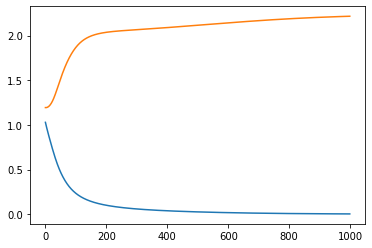

In [0]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

valN = 64
valx = torch.randn(valN,128)
valy = torch.randn(valN,2)

valdataset = TensorDataset(valx,valy)
valdataloader = DataLoader(valdataset,batch_size=64)

myNet = myMLP(128,2,256).cuda()

optimizer = optim.SGD(myNet.parameters(),lr=1e-2,weight_decay=1e-3)

criterion = nn.MSELoss().cuda()

losses = []
vallosses = []
epochNum = 1000
bestLoss = 10000

for i in range(epochNum):
  # Train
  running_loss = 0
  
  for x,y in dataloader:
    x = x.cuda()
    y = y.cuda()
    optimizer.zero_grad()
    y_pred = myNet(x)
    loss = criterion(y_pred,y)
    loss.backward()
    optimizer.step()
    running_loss += loss.cpu().item()
  running_loss /= len(dataloader)
  losses.append(running_loss)
  
  #Val
  running_loss = 0
  
  for x,y in valdataloader:
    x = x.cuda()
    y = y.cuda()
    y_pred = myNet(x)
    loss = criterion(y_pred,y)
    running_loss += loss.cpu().item()
  running_loss /= len(valdataloader)
  vallosses.append(running_loss)
  if running_loss < bestLoss:
    bestLoss = running_loss
    torch.save(myNet.state_dict(),"myNet.pth")
    
print(bestLoss)
plt.plot(losses)
plt.plot(vallosses)
plt.show()
  

## Értelmes adat tanítása